In [330]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [331]:
def f(x):
    return 3*x**2 - 4*x + 5
f(3.0)

20.0

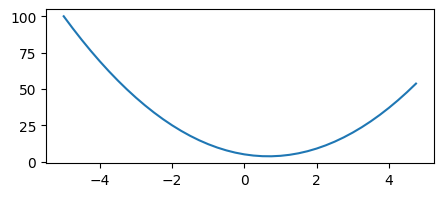

In [332]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.figure(figsize=(5,2))
plt.plot(xs, ys)

In [333]:
h = 0.00000001 #dx
x = -3.0
(f(x + h) - f(x))/h

-22.00000039920269

In [334]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h #change this to b or c, how does taking the derivative relative to diff vars change the slope
d2 = a * b + c
print ("d1", d1)
print ("d2", d2)
print ("slope", (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [335]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

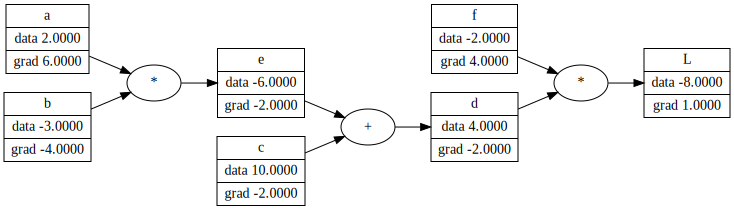

In [336]:
from graphviz import Digraph
# Ran these 2 lines once and it made it work, even when adding manually didn't *shrug*
# import os
# os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin'

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = " %s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

L.grad = 1
L.backward()
draw_dot(L)

In [337]:

###Chain rule, how is L affected by e? b? a?

# dl/de = dl/dd * dd/de = -2 * 1
# dl/da = dl/dd * dd/de * de/da = -2 * 1 * -3
#plus nodes always have gradient of 1, so it just routes the gradient to the next node

def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    l = d * f; l.label = 'l'
    L1 = l.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    l = d * f; l.label = 'l'
    L2 = l.data

    print((L2 - L1)/h)

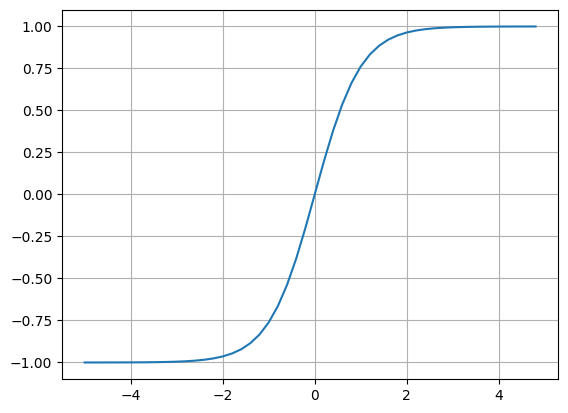

In [338]:
# 53min - squashing function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

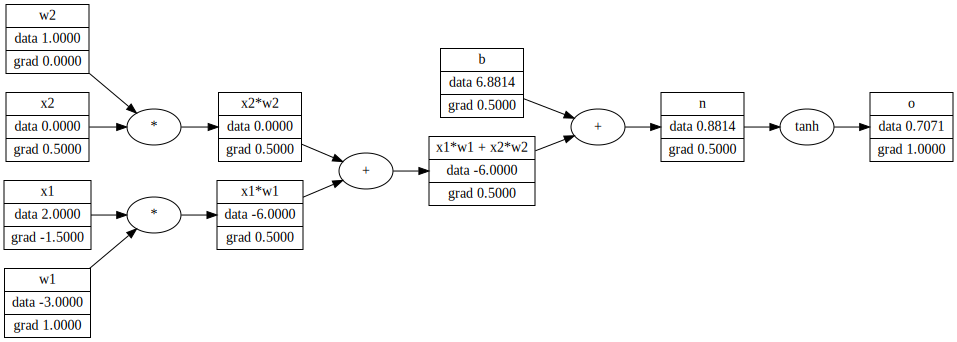

In [339]:
#55min
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

In [340]:
import torch

x1 = torch.Tensor([2.0]).double();
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [341]:
import random


class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [342]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
# n.parameters()

Value(data=0.7752656751351278)

In [343]:
# 1:52min
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred #want the first to be 1.0, 2nd to be -1.0, 3rd to be -1.0, etc...

[Value(data=0.7752656751351278),
 Value(data=0.659559417572283),
 Value(data=0.6571348947267692),
 Value(data=0.3936218386800274)]

In [344]:
t = 10
for k in range(t):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) #1:52min
  print(loss)

  # backward pass
  oldpgrad = n.parameters()[0].grad
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  print("%4.f", oldpgrad - n.parameters()[0].grad)

  if k == t:
      print(k, loss.data)

Value(data=5.918433511072216)
%4.f 0.08428177782160204
Value(data=3.751561657376042)
%4.f -0.667375178852718
Value(data=3.323225802656968)
%4.f 0.5411337107825206
Value(data=3.208910250207415)
%4.f -1.1545223053324005
Value(data=2.1629126451840675)
%4.f 1.2865074287853229
Value(data=0.26729303324448284)
%4.f -0.2661806529914858
Value(data=0.10868791459198747)
%4.f 0.14947410521741203
Value(data=0.07802184224638593)
%4.f 0.004302541717801079
Value(data=0.060620651841047285)
%4.f 0.004069759139749461
Value(data=0.049374726826446586)
%4.f 0.0030591514678060747


In [345]:
ypred

[Value(data=0.9549467690106304),
 Value(data=-0.9444729604989273),
 Value(data=-0.839480053286961),
 Value(data=0.8640035743287549)]